In [1]:
%matplotlib inline
%load_ext tensorboard

## Prerequisite Python Modules

First, some software needs to be loaded into the Python environment.

In [2]:
import numpy as np                   # advanced math library
import matplotlib.pyplot as plt      # MATLAB like plotting routines
import random                        # for generating random numbers
import tensorflow as tf

from keras.datasets import mnist     # MNIST dataset is included in Keras%
from keras.models import Sequential  # Model type to be used

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Activation # Types of layers to be used in our model
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Flatten, ReLU, AveragePooling2D
from keras.layers import BatchNormalization
from keras.utils import to_categorical                         # NumPy related tools

from tensorflow.keras import optimizers


from sklearn.metrics import confusion_matrix
import itertools

logdir = "logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

2025-04-16 23:11:24.357338: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744837884.370673   64529 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744837884.374914   64529 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744837884.385342   64529 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744837884.385359   64529 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744837884.385361   64529 computation_placer.cc:177] computation placer alr

In [3]:
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
if len(gpus) > 0:
    print("Using GPU:", gpus)
    # for gpu in gpus:
    #   tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPU detected. Ensure TensorFlow is installed with GPU support.")
    exit(1)

Num GPUs Available:  1
Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# CIFAR-10

## Ładowanie zbioru danych

In [4]:
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = X_train.astype('float32')         # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                              # normalize each value for each pixel for the entire vector for each input
X_test /= 255

y_train = y_train.reshape((1,-1))[0]
y_test = y_test.reshape((1,-1))[0]

print("Training matrix shape", X_train.shape, y_train.shape)
print("Testing matrix shape", X_test.shape, y_test.shape)

# one-hot format classes

nb_classes = 10

Y_train = to_categorical(y_train, nb_classes)
Y_test = to_categorical(y_test, nb_classes)

cifar_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Training matrix shape (50000, 32, 32, 3) (50000,)
Testing matrix shape (10000, 32, 32, 3) (10000,)


## Podgląd zbioru treningowego

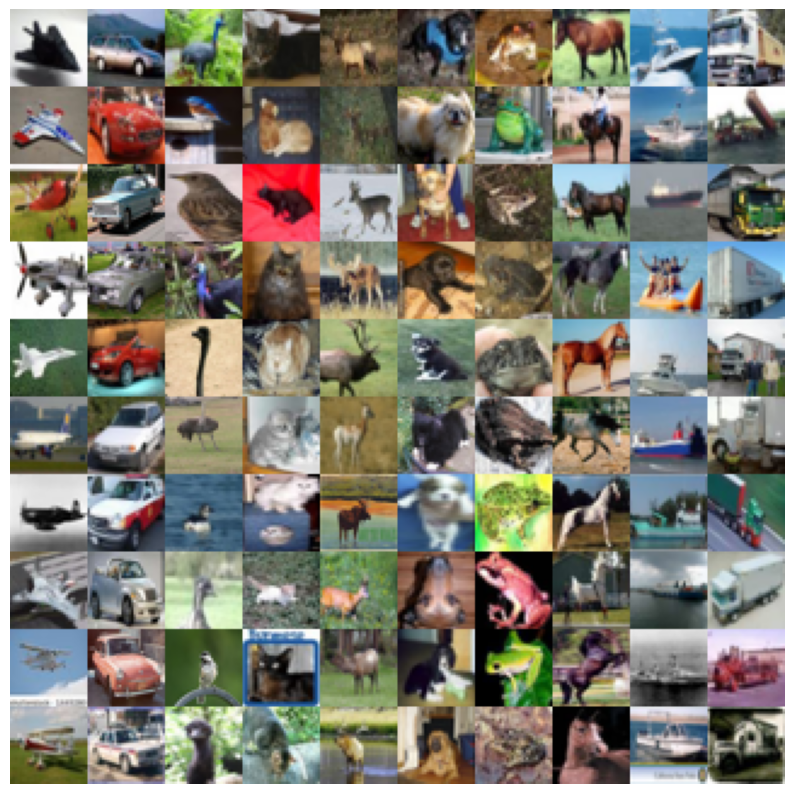

In [5]:
for i in range(0, 10):
  img_batch = X_train[y_train == i][0:10]
  img_batch = np.reshape(img_batch, (img_batch.shape[0]*img_batch.shape[1], img_batch.shape[2], img_batch.shape[3]))
  if i > 0:
    img = np.concatenate([img, img_batch], axis = 1)
  else:
    img = img_batch
plt.figure(figsize=(10,20))
plt.axis('off')
plt.imshow(img, cmap='gray')


## Przygotowanie modelu

In [6]:
def generate_model():
  model = Sequential()

  model.add(Conv2D(64, (3, 3), padding='same', input_shape=(32, 32, 3)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Dropout(0.2))

  model.add(Conv2D(128, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(128, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(256, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(256, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(256, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())

  model.add(Dropout(0.5))

  model.add(Dense(1024))
  model.add(Activation('relu'))
  model.add(Dense(1024))
  model.add(Activation('relu'))

  model.add(Dense(10))
  model.add(Activation('softmax'))


  model.summary()

  adam = optimizers.AdamW(learning_rate=0.001, weight_decay=1e-4)
  model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'], jit_compile=False)

  return model

In [7]:
model = generate_model()

/home/tomek/twm/TWM/lab4/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1744837888.060895   64529 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1035 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 256)      │       590,08

 Total params: 6,995,274 (26.68 MB)

 Trainable params: 6,992,970 (26.68 MB)

 Non-trainable params: 2,304 (9.00 KB)

## Trening

In [8]:
epochs = 40
batch_size = 128

In [9]:
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08, validation_split=0.2)

train_generator = gen.flow(X_train, Y_train, batch_size=batch_size, subset='training')
valid_generator = gen.flow(X_train, Y_train, batch_size=batch_size, subset='validation')

In [10]:
model.fit(
    train_generator,
    steps_per_epoch=40000//batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=valid_generator,
    validation_steps = 10000 // batch_size,
    callbacks=[tensorboard_callback]
)

/home/tomek/twm/TWM/lab4/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40


E0000 00:00:1744837892.254284   64529 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1744837892.560483   64593 cuda_dnn.cc:529] Loaded cuDNN version 90300


311/312 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2204 - loss: 2.6255

2025-04-16 23:11:52.346824: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1006632960 exceeds 10% of free system memory.


312/312 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.2210 - loss: 2.6210 - val_accuracy: 0.1851 - val_loss: 2.3977
Epoch 2/40
  1/312 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.4609 - loss: 1.4284

/home/tomek/twm/TWM/lab4/.venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2025-04-16 23:11:56.157654: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1006632960 exceeds 10% of free system memory.


312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4609 - loss: 1.4284 - val_accuracy: 0.1948 - val_loss: 2.4396
Epoch 3/40
311/312 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4984 - loss: 1.3649

2025-04-16 23:12:13.637464: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1006632960 exceeds 10% of free system memory.


312/312 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - accuracy: 0.4986 - loss: 1.3644 - val_accuracy: 0.4873 - val_loss: 1.4932
Epoch 4/40
  1/312 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.5469 - loss: 1.2159

2025-04-16 23:12:17.473054: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1006632960 exceeds 10% of free system memory.


312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5469 - loss: 1.2159 - val_accuracy: 0.4844 - val_loss: 1.4825
Epoch 5/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6032 - loss: 1.0962

2025-04-16 23:12:34.836159: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1006632960 exceeds 10% of free system memory.


312/312 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - accuracy: 0.6032 - loss: 1.0960 - val_accuracy: 0.5692 - val_loss: 1.2736
Epoch 6/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7188 - loss: 0.7624 - val_accuracy: 0.5405 - val_loss: 1.3683
Epoch 7/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - accuracy: 0.6803 - loss: 0.9014 - val_accuracy: 0.6508 - val_loss: 0.9952
Epoch 8/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6562 - loss: 1.0732 - val_accuracy: 0.6505 - val_loss: 1.0033
Epoch 9/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - accuracy: 0.7311 - loss: 0.7703 - val_accuracy: 0.6973 - val_loss: 0.8707
Epoch 10/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7031 - loss: 0.7648 - val_accuracy: 0.6802 - val_loss: 0.9260
Epoch 11/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - accuracy: 0.7574 - loss: 0.6971 - val_accuracy: 0.7166 - val_loss: 0.8036
Epoch 12/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7656 - loss: 0.6703 - val_accuracy

## Test

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8228 - loss: 0.5605
Test score: 0.5818271040916443
Test accuracy: 0.8181999921798706
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Confusion matrix, without normalization
[[863  16  32   2   5   4  23   8  33  14]
 [  2 981   1   0   0   0   5   1   2   8]
 [ 56   4 789  19  22  24  76   7   1   2]
 [ 25  10  76 570  30 127 124  23   7   8]
 [ 15   2  87  16 759  20  76  23   1   1]
 [  8   8  63  77  23 735  45  38   2   1]
 [  3   3  26   9   6   6 943   1   3   0]
 [ 14   6  19  13  25  29  17 869   2   6]
 [ 53  44  16   8   0   3  10   2 847  17]
 [ 16 136   5   4   1   1   9   0   2 826]]


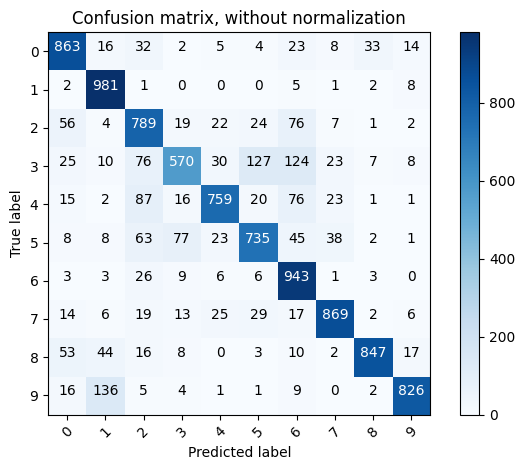

In [11]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
#predicted_classes = model.predict_classes(X_test)
predict_x=model.predict(X_test)
predicted_classes=np.argmax(predict_x,axis=1)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]

incorrect_indices = np.nonzero(predicted_classes != y_test)[0]


cnf_matrix = confusion_matrix(y_test, predicted_classes)

class_names = [str(i) for i in range(10)]

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

In [12]:
def show_samples_rgb(indices, preds, images, labels, count=3, names = []):
    plt.figure(figsize = (10, 10))
    for i, sample in enumerate(indices[:count**2]):
        pred_id = int(np.argmax(preds[sample]))
        real_id = int(labels[sample])
        pred_score = preds[sample][pred_id]
        real_score = preds[sample][real_id]
        plt.subplot(count,count,i+1)
        plt.imshow(images[sample], interpolation='none')
        plt.axis('off')
        if len(names) > 0:
          plt.title("P: {} ({:.2f})\nE: {} ({:.2f})".format(names[pred_id], pred_score, names[real_id], real_score))
        else:
          plt.title("P: {} ({:.2f})\nE: {} ({:.2f})".format(pred_id, pred_score, real_id, real_score))

    plt.tight_layout()

## Poprawne klasyfikacje

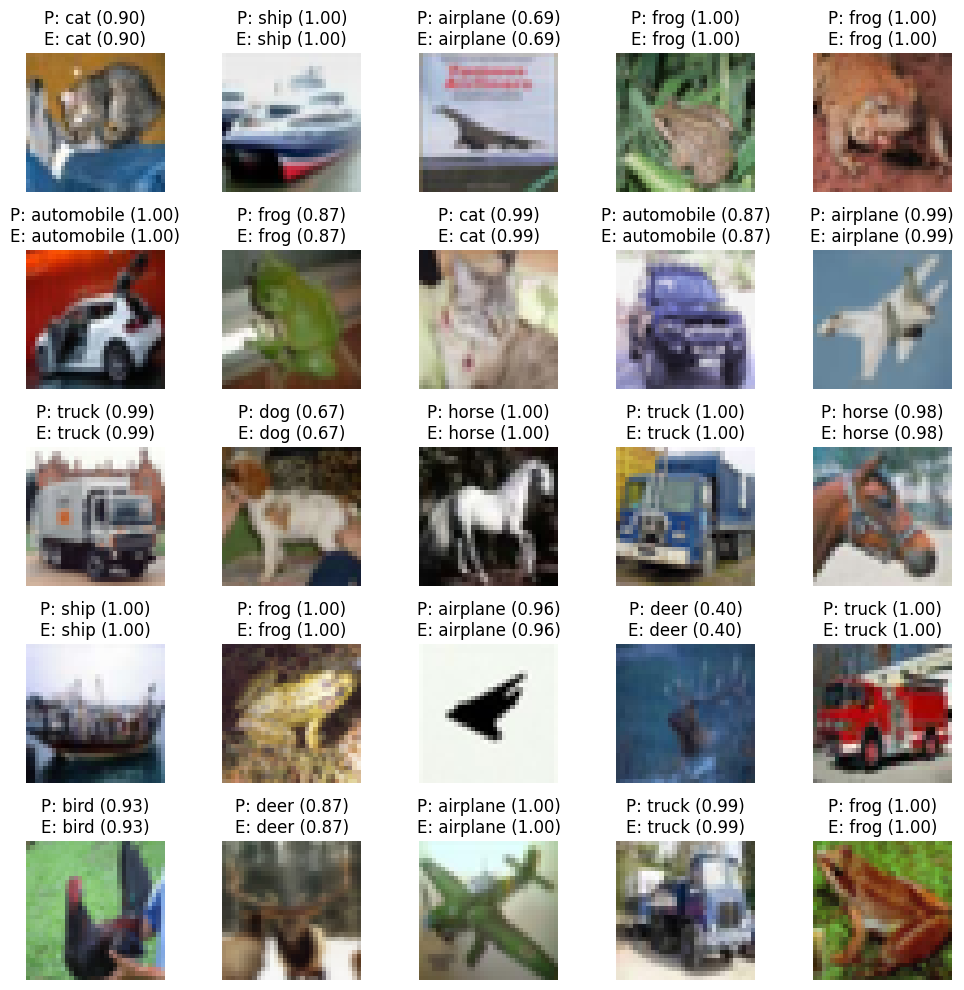

In [13]:
show_samples_rgb(correct_indices, predict_x, X_test, y_test, 5, cifar_names)

## Błędne klasyfikacje

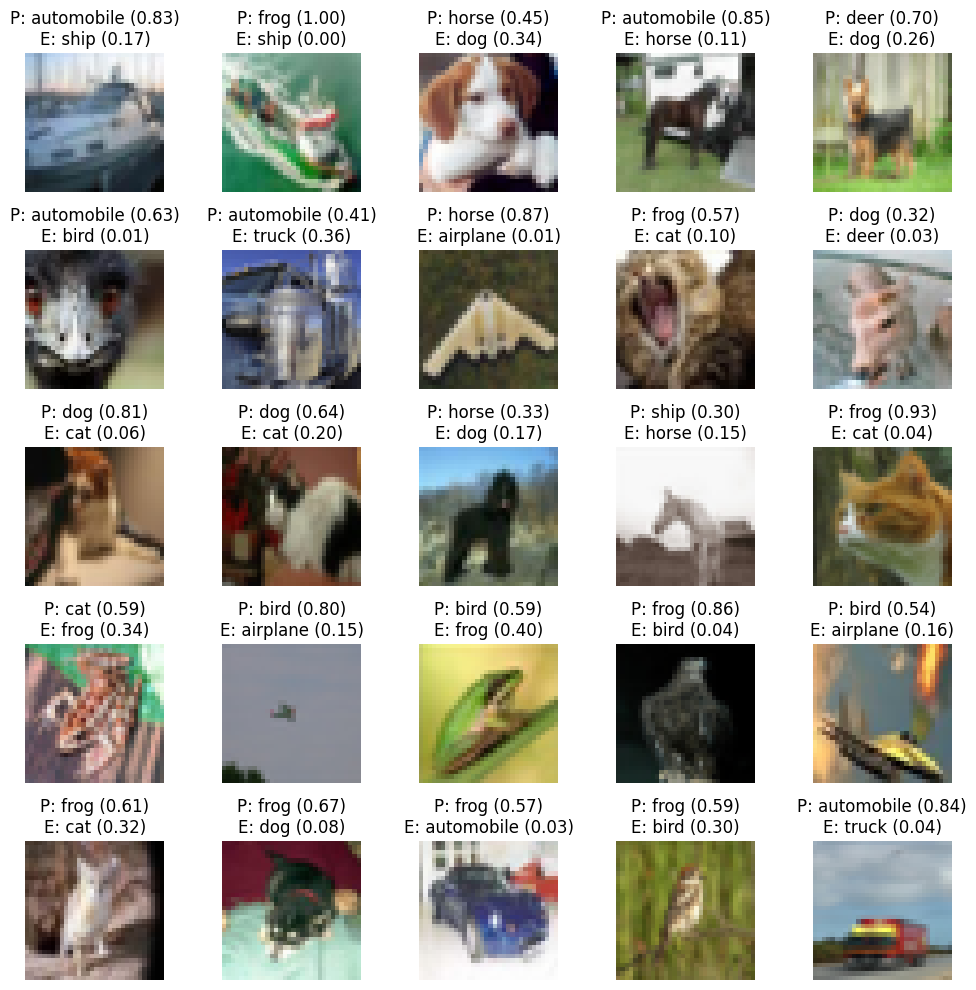

In [14]:
show_samples_rgb(incorrect_indices, predict_x, X_test, y_test, 5, cifar_names)